First let's **load the data**

In [183]:
import pandas as pd
import numpy as np
import os, sys

In [184]:
df = pd.read_csv('parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


Then let's get the **features** and **labels**

In [185]:
features = df.loc[:, df.columns != 'status'].values[:, 1:]
labels = df.loc[:, 'status'].values

Let's do a quick sweep to see what the data looks like in terms of signal:

In [186]:
labels[labels == 1].shape[0], labels[labels == 0].shape[0]

(147, 48)

Not too good... we have about triple the number of observations for one label as the other, and not many total datapoints. We'll make do!

Next let's **scale** the data between -1 and 1. Our labels can stay 0 and 1.

In [187]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1, 1))
X = scaler.fit_transform(features)
Y = labels

Next split the training set. I found 14% test works great for my random seed.

In [188]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.14, random_state=7)

And finally, **fit** the XGBoosting model.

In [189]:
# Train
model = XGBClassifier()
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [190]:
# Evaluate
Y_hat = [round(yhat) for yhat in model.predict(X_test)]
print(accuracy_score(Y_test, Y_hat)) # Test set accuracy
Y_hat = [round(yhat) for yhat in model.predict(X)]
print(accuracy_score(Y, Y_hat)) # Full set accuracy

0.9642857142857143
0.9948717948717949


Great! Without any tuning we were able to get 96.43% accuracy. We can do better with some fine tuning later.

Next, let's take a stab at the UPDRS data. Same process to load the data.

In [191]:
udf = pd.read_csv('parkinsons_updrs.data')
udf.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


**Careful!** This data has multioutput so we'll have to dress out features and labels accordingly. 

We're trying to predict motor and total UPDRS (as per [this](https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.names))

In [192]:
features = udf.loc[:, (udf.columns != 'motor_UPDRS') & (udf.columns != 'total_UPDRS')].values[:, 1:]
labels = udf.loc[:, (udf.columns == 'motor_UPDRS') | (udf.columns == 'total_UPDRS')].values

We scale both the features and labels since the labels are continuous this time.

In [193]:
X = scaler.fit_transform(features)
Y = scaler.fit_transform(labels)

Let's go with 10% test size.

In [263]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=7)

This data may be better suited to a NN so let's use Keras this time.

In [284]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

We can make a simple Sequential model. We'll use tanh as our activation, sgd as the optimizer, and mse as our loss since this is a continuous problem. We can also afford to validate with 25% of our data. Set batch size to 1 because we can handle it!

In [290]:
u_model = Sequential()
u_model.add(Dense(32, input_shape=(X.shape[1],)))
u_model.add(Dense(16, activation='tanh'))
u_model.add(Dense(8, activation='tanh'))
u_model.add(Dense(72, activation='tanh'))
u_model.add(Dense(Y.shape[1], activation='tanh'))
u_model.compile(optimizer='sgd', loss='mean_squared_error')
u_model.fit(X_train, Y_train, batch_size=1, epochs=5, validation_split=0.25, shuffle=True)

Train on 3965 samples, validate on 1322 samples
Epoch 1/5
3965/3965 [==============================] - 4s 1ms/step - loss: 0.1906 - val_loss: 0.1944
Epoch 2/5
3965/3965 [==============================] - 4s 1ms/step - loss: 0.1659 - val_loss: 0.1551
Epoch 3/5
3965/3965 [==============================] - 4s 1ms/step - loss: 0.1506 - val_loss: 0.1628
Epoch 4/5
3965/3965 [==============================] - 4s 1ms/step - loss: 0.1466 - val_loss: 0.1444
Epoch 5/5
3965/3965 [==============================] - 4s 1ms/step - loss: 0.1412 - val_loss: 0.1444


We can see it's training just fine. Let's train to 20 total epochs (15 more) and see if it levels off.

In [291]:
u_model.fit(X_train, Y_train, batch_size=1, epochs=15, validation_split=0.25, shuffle=True)

Train on 3965 samples, validate on 1322 samples
Epoch 1/15
3965/3965 [==============================] - 5s 1ms/step - loss: 0.1367 - val_loss: 0.1287
Epoch 2/15
3965/3965 [==============================] - 4s 1ms/step - loss: 0.1321 - val_loss: 0.1295
Epoch 3/15
3965/3965 [==============================] - 5s 1ms/step - loss: 0.1283 - val_loss: 0.1321
Epoch 4/15
3965/3965 [==============================] - 4s 1ms/step - loss: 0.1260 - val_loss: 0.1306
Epoch 5/15
3965/3965 [==============================] - 4s 1ms/step - loss: 0.1231 - val_loss: 0.1545
Epoch 6/15
3965/3965 [==============================] - 5s 1ms/step - loss: 0.1191 - val_loss: 0.1730
Epoch 7/15
3965/3965 [==============================] - 4s 1ms/step - loss: 0.1178 - val_loss: 0.1147
Epoch 8/15
3965/3965 [==============================] - 4s 1ms/step - loss: 0.1163 - val_loss: 0.1369
Epoch 9/15
3965/3965 [==============================] - 4s 1ms/step - loss: 0.1142 - val_loss: 0.1147
Epoch 10/15
3965/3965 [===========

Seems like it's still got a bit to go before the minima--I tested it and found that it levels off around 70 total epochs (55 more).

In [ ]:
u_model.fit(X_train, Y_train, batch_size=1, epochs=55, validation_split=0.25, shuffle=True)

Train on 3965 samples, validate on 1322 samples
Epoch 1/55
3965/3965 [==============================] - 4s 1ms/step - loss: 0.0634 - val_loss: 0.0697
Epoch 2/55
3965/3965 [==============================] - 4s 1ms/step - loss: 0.0623 - val_loss: 0.0663
Epoch 3/55
3965/3965 [==============================] - 4s 1ms/step - loss: 0.0611 - val_loss: 0.0625
Epoch 4/55
3965/3965 [==============================] - 5s 1ms/step - loss: 0.0612 - val_loss: 0.0629
Epoch 5/55
3965/3965 [==============================] - 4s 1ms/step - loss: 0.0588 - val_loss: 0.0634
Epoch 6/55
3965/3965 [==============================] - 4s 1ms/step - loss: 0.0603 - val_loss: 0.0612
Epoch 7/55
3965/3965 [==============================] - 4s 1ms/step - loss: 0.0587 - val_loss: 0.0616
Epoch 8/55
3965/3965 [==============================] - 4s 1ms/step - loss: 0.0580 - val_loss: 0.0678
Epoch 9/55
3965/3965 [==============================] - 4s 1ms/step - loss: 0.0584 - val_loss: 0.0649
Epoch 10/55
3965/3965 [===========

Keep fitting at 5 epochs until you see loss and val_loss level out and stop decreasing.

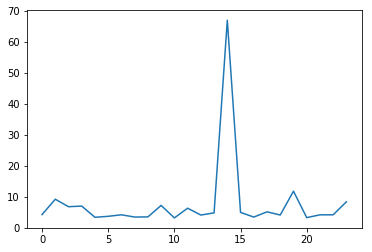

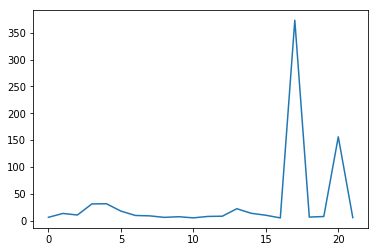

In [310]:
Y_hat = u_model.predict(X_test)
error = np.abs((Y_hat - Y_test) / Y_test)
plt.show(plt.plot(error[:, 0][error[:, 0] > 3]))
plt.show(plt.plot(error[:, 1][error[:, 1] > 5]))